# 01_femto_eda.ipynb

Denna notebook används för att:
- Utforska FEMTO vibrationsdata (B1_1_long_fs200.csv)
- Skapa features (ax, ay, magnitud, differenser)
- Träna en Isolation Forest-modell
- Utvärdera modellens beteende före driftsättning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from joblib import dump
from glob import glob
import os, gc


In [ ]:
"""
Femto Bearing Dataset – robust inläsning och feature-extraktion.
Tillåter nu filer med fler än 6 kolumner (de två sista tas som ax, ay).
Endast acc_*.csv-filer processas.
"""

import os, gc
import numpy as np
import pandas as pd
import pyarrow as pa, pyarrow.parquet as pq
from glob import glob
from collections import Counter

# === Sökvägar ===
BASE = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/training"
OUT  = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_train.parquet"

# === Initiering ===
if os.path.exists(OUT):
    os.remove(OUT)

csv_files = glob(os.path.join(BASE, "Bearing*","acc_*.csv"))
print(f"Hittade totalt {len(csv_files):,} acc_*.csv-filer")

ok_count, skip_count = 0, 0
error_reasons = Counter()
writer = None

# === Ny, tolerant inläsningsfunktion ===
def read_one_csv(path: str) -> pd.DataFrame:
    try:
        # Auto-detektera separator
        df = pd.read_csv(path, header=None, sep=None, engine="python", low_memory=False)
    except Exception:
        df = None

    if df is None or df.shape[1] == 1:
        for sep in [",",";","\t"," "]:
            try:
                df = pd.read_csv(path, header=None, sep=sep, engine="c", low_memory=False)
                break
            except Exception:
                continue

    if df is None or df.empty:
        raise ValueError("tom/oläsbar fil")

    n = df.shape[1]
    if n < 2:
        raise ValueError(f"oväntat antal kolumner: {n} (förväntade ≥2)")

    # Ta de två sista kolumnerna som ax, ay
    ax = pd.to_numeric(df.iloc[:, -2], errors="coerce")
    ay = pd.to_numeric(df.iloc[:, -1], errors="coerce")

    out = pd.DataFrame({"ax": ax, "ay": ay}).dropna()

    # Features
    out["mag"]      = np.sqrt(out["ax"]**2 + out["ay"]**2)
    out["ax_diff"]  = out["ax"].diff().fillna(0)
    out["ay_diff"]  = out["ay"].diff().fillna(0)
    out["mag_diff"] = out["mag"].diff().fillna(0)
    out["source_file"] = os.path.basename(path)

    return out.astype({
        "ax":"float32","ay":"float32","mag":"float32",
        "ax_diff":"float32","ay_diff":"float32","mag_diff":"float32"
    })

# === Huvudloop ===
for i, f in enumerate(csv_files, 1):
    try:
        feat = read_one_csv(f)
        table = pa.Table.from_pandas(feat, preserve_index=False)

        if writer is None:
            writer = pq.ParquetWriter(OUT, table.schema, compression="zstd")

        writer.write_table(table)
        ok_count += 1

        # Frigör RAM
        del feat
        gc.collect()

    except Exception as e:
        skip_count += 1
        reason = str(e).split(":")[0]
        error_reasons[reason] += 1

        if skip_count <= 10:
            print(f"⚠️ Hoppar över {os.path.basename(f)}: {e}")

    if i % 200 == 0:
        print(f"...bearbetat {i} filer (OK={ok_count}, hoppade över={skip_count})")

if writer:
    writer.close()

# === Sammanfattning ===
print("\n✅ KLART!")
print(f"OK: {ok_count:,} filer")
print(f"Hoppade över: {skip_count:,} filer")
print(f"Features sparade → {OUT}")

print("\nTopp felorsaker:")
for r, c in error_reasons.most_common(5):
    print(f"  {r}: {c} st")


Hittade totalt 7,534 acc_*.csv-filer
...bearbetat 200 filer (OK=200, skip=0)
...bearbetat 400 filer (OK=400, skip=0)
...bearbetat 600 filer (OK=600, skip=0)
...bearbetat 800 filer (OK=800, skip=0)
...bearbetat 1000 filer (OK=1000, skip=0)
...bearbetat 1200 filer (OK=1200, skip=0)
...bearbetat 1400 filer (OK=1400, skip=0)
...bearbetat 1600 filer (OK=1600, skip=0)
...bearbetat 1800 filer (OK=1800, skip=0)
...bearbetat 2000 filer (OK=2000, skip=0)
...bearbetat 2200 filer (OK=2200, skip=0)
...bearbetat 2400 filer (OK=2400, skip=0)
...bearbetat 2600 filer (OK=2600, skip=0)
...bearbetat 2800 filer (OK=2800, skip=0)
...bearbetat 3000 filer (OK=3000, skip=0)
...bearbetat 3200 filer (OK=3200, skip=0)
...bearbetat 3400 filer (OK=3400, skip=0)
...bearbetat 3600 filer (OK=3600, skip=0)
...bearbetat 3800 filer (OK=3800, skip=0)
...bearbetat 4000 filer (OK=4000, skip=0)
...bearbetat 4200 filer (OK=4200, skip=0)
...bearbetat 4400 filer (OK=4400, skip=0)
...bearbetat 4600 filer (OK=4600, skip=0)
...be

In [ ]:
"""
Femto Bearing Dataset – robust inläsning och feature-extraktion.
Tillåter nu filer med fler än 6 kolumner (de två sista tas som ax, ay).
Endast acc_*.csv-filer processas.
"""

import os, gc
import numpy as np
import pandas as pd
import pyarrow as pa, pyarrow.parquet as pq
from glob import glob
from collections import Counter

# === Sökvägar ===
BASE = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/validation"
OUT  = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_val.parquet"

# === Initiering ===
if os.path.exists(OUT):
    os.remove(OUT)

csv_files = glob(os.path.join(BASE, "Bearing*","acc_*.csv"))
print(f"Hittade totalt {len(csv_files):,} acc_*.csv-filer")

ok_count, skip_count = 0, 0
error_reasons = Counter()
writer = None

# === Ny, tolerant inläsningsfunktion ===
def read_one_csv(path: str) -> pd.DataFrame:
    try:
        # Auto-detektera separator
        df = pd.read_csv(path, header=None, sep=None, engine="python", low_memory=False)
    except Exception:
        df = None

    if df is None or df.shape[1] == 1:
        for sep in [",",";","\t"," "]:
            try:
                df = pd.read_csv(path, header=None, sep=sep, engine="c", low_memory=False)
                break
            except Exception:
                continue

    if df is None or df.empty:
        raise ValueError("tom/oläsbar fil")

    n = df.shape[1]
    if n < 2:
        raise ValueError(f"oväntat antal kolumner: {n} (förväntade ≥2)")

    # Ta de två sista kolumnerna som ax, ay
    ax = pd.to_numeric(df.iloc[:, -2], errors="coerce")
    ay = pd.to_numeric(df.iloc[:, -1], errors="coerce")

    out = pd.DataFrame({"ax": ax, "ay": ay}).dropna()

    # Features
    out["mag"]      = np.sqrt(out["ax"]**2 + out["ay"]**2)
    out["ax_diff"]  = out["ax"].diff().fillna(0)
    out["ay_diff"]  = out["ay"].diff().fillna(0)
    out["mag_diff"] = out["mag"].diff().fillna(0)
    out["source_file"] = os.path.basename(path)

    return out.astype({
        "ax":"float32","ay":"float32","mag":"float32",
        "ax_diff":"float32","ay_diff":"float32","mag_diff":"float32"
    })

# === Huvudloop ===
for i, f in enumerate(csv_files, 1):
    try:
        feat = read_one_csv(f)
        table = pa.Table.from_pandas(feat, preserve_index=False)

        if writer is None:
            writer = pq.ParquetWriter(OUT, table.schema, compression="zstd")

        writer.write_table(table)
        ok_count += 1

        # Frigör RAM
        del feat
        gc.collect()

    except Exception as e:
        skip_count += 1
        reason = str(e).split(":")[0]
        error_reasons[reason] += 1

        if skip_count <= 10:
            print(f"⚠️ Hoppar över {os.path.basename(f)}: {e}")

    if i % 200 == 0:
        print(f"...bearbetat {i} filer (OK={ok_count}, hoppade över={skip_count})")

if writer:
    writer.close()

# === Sammanfattning ===
print("\n✅ KLART!")
print(f"OK: {ok_count:,} filer")
print(f"Hoppade över: {skip_count:,} filer")
print(f"Features sparade → {OUT}")

print("\nTopp felorsaker:")
for r, c in error_reasons.most_common(5):
    print(f"  {r}: {c} st")


Hittade totalt 17,355 acc_*.csv-filer
...bearbetat 200 filer (OK=200, skip=0)
...bearbetat 400 filer (OK=400, skip=0)
...bearbetat 600 filer (OK=600, skip=0)
...bearbetat 800 filer (OK=800, skip=0)
...bearbetat 1000 filer (OK=1000, skip=0)
...bearbetat 1200 filer (OK=1200, skip=0)
...bearbetat 1400 filer (OK=1400, skip=0)
...bearbetat 1600 filer (OK=1600, skip=0)
...bearbetat 1800 filer (OK=1800, skip=0)
...bearbetat 2000 filer (OK=2000, skip=0)
...bearbetat 2200 filer (OK=2200, skip=0)
...bearbetat 2400 filer (OK=2400, skip=0)
...bearbetat 2600 filer (OK=2600, skip=0)
...bearbetat 2800 filer (OK=2800, skip=0)
...bearbetat 3000 filer (OK=3000, skip=0)
...bearbetat 3200 filer (OK=3200, skip=0)
...bearbetat 3400 filer (OK=3400, skip=0)
...bearbetat 3600 filer (OK=3600, skip=0)
...bearbetat 3800 filer (OK=3800, skip=0)
...bearbetat 4000 filer (OK=4000, skip=0)
...bearbetat 4200 filer (OK=4200, skip=0)
...bearbetat 4400 filer (OK=4400, skip=0)
...bearbetat 4600 filer (OK=4600, skip=0)
...b

In [ ]:
"""
Femto Bearing Dataset – robust inläsning och feature-extraktion.
Tillåter nu filer med fler än 6 kolumner (de två sista tas som ax, ay).
Endast acc_*.csv-filer processas.
"""

import os, gc
import numpy as np
import pandas as pd
import pyarrow as pa, pyarrow.parquet as pq
from glob import glob
from collections import Counter

# === Sökvägar ===

BASE = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/test"
OUT  = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_test.parquet"

# === Initiering ===
if os.path.exists(OUT):
    os.remove(OUT)

csv_files = glob(os.path.join(BASE, "Bearing*","acc_*.csv"))
print(f"Hittade totalt {len(csv_files):,} acc_*.csv-filer")

ok_count, skip_count = 0, 0
error_reasons = Counter()
writer = None

# === Ny, tolerant inläsningsfunktion ===
def read_one_csv(path: str) -> pd.DataFrame:
    try:
        # Auto-detektera separator
        df = pd.read_csv(path, header=None, sep=None, engine="python", low_memory=False)
    except Exception:
        df = None

    if df is None or df.shape[1] == 1:
        for sep in [",",";","\t"," "]:
            try:
                df = pd.read_csv(path, header=None, sep=sep, engine="c", low_memory=False)
                break
            except Exception:
                continue

    if df is None or df.empty:
        raise ValueError("tom/oläsbar fil")

    n = df.shape[1]
    if n < 2:
        raise ValueError(f"oväntat antal kolumner: {n} (förväntade ≥2)")

    # Ta de två sista kolumnerna som ax, ay
    ax = pd.to_numeric(df.iloc[:, -2], errors="coerce")
    ay = pd.to_numeric(df.iloc[:, -1], errors="coerce")

    out = pd.DataFrame({"ax": ax, "ay": ay}).dropna()

    # Features
    out["mag"]      = np.sqrt(out["ax"]**2 + out["ay"]**2)
    out["ax_diff"]  = out["ax"].diff().fillna(0)
    out["ay_diff"]  = out["ay"].diff().fillna(0)
    out["mag_diff"] = out["mag"].diff().fillna(0)
    out["source_file"] = os.path.basename(path)

    return out.astype({
        "ax":"float32","ay":"float32","mag":"float32",
        "ax_diff":"float32","ay_diff":"float32","mag_diff":"float32"
    })

# === Huvudloop ===
for i, f in enumerate(csv_files, 1):
    try:
        feat = read_one_csv(f)
        table = pa.Table.from_pandas(feat, preserve_index=False)

        if writer is None:
            writer = pq.ParquetWriter(OUT, table.schema, compression="zstd")

        writer.write_table(table)
        ok_count += 1

        # Frigör RAM
        del feat
        gc.collect()

    except Exception as e:
        skip_count += 1
        reason = str(e).split(":")[0]
        error_reasons[reason] += 1

        if skip_count <= 10:
            print(f"⚠️ Hoppar över {os.path.basename(f)}: {e}")

    if i % 200 == 0:
        print(f"...bearbetat {i} filer (OK={ok_count}, hoppade över={skip_count})")

if writer:
    writer.close()

# === Sammanfattning ===
print("\n✅ KLART!")
print(f"OK: {ok_count:,} filer")
print(f"Hoppade över: {skip_count:,} filer")
print(f"Features sparade → {OUT}")

print("\nTopp felorsaker:")
for r, c in error_reasons.most_common(5):
    print(f"  {r}: {c} st")


Hittade totalt 13,959 acc_*.csv-filer
...bearbetat 200 filer (OK=200, skip=0)
...bearbetat 400 filer (OK=400, skip=0)
...bearbetat 600 filer (OK=600, skip=0)
...bearbetat 800 filer (OK=800, skip=0)
...bearbetat 1000 filer (OK=1000, skip=0)
...bearbetat 1200 filer (OK=1200, skip=0)
...bearbetat 1400 filer (OK=1400, skip=0)
...bearbetat 1600 filer (OK=1600, skip=0)
...bearbetat 1800 filer (OK=1800, skip=0)
...bearbetat 2000 filer (OK=2000, skip=0)
...bearbetat 2200 filer (OK=2200, skip=0)
...bearbetat 2400 filer (OK=2400, skip=0)
...bearbetat 2600 filer (OK=2600, skip=0)
...bearbetat 2800 filer (OK=2800, skip=0)
...bearbetat 3000 filer (OK=3000, skip=0)
...bearbetat 3200 filer (OK=3200, skip=0)
...bearbetat 3400 filer (OK=3400, skip=0)
...bearbetat 3600 filer (OK=3600, skip=0)
...bearbetat 3800 filer (OK=3800, skip=0)
...bearbetat 4000 filer (OK=4000, skip=0)
...bearbetat 4200 filer (OK=4200, skip=0)
...bearbetat 4400 filer (OK=4400, skip=0)
...bearbetat 4600 filer (OK=4600, skip=0)
...b

In [ ]:
import os, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from joblib import dump

TRAIN = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_train.parquet"
VAL   = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_val.parquet"
TEST  = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_test.parquet"

FEATURES = ["ax","ay","mag","ax_diff","ay_diff","mag_diff"]

df_tr = pd.read_parquet(TRAIN)
X_tr  = df_tr[FEATURES].values

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("iforest", IsolationForest(n_estimators=200, contamination=0.03, random_state=42))
]).fit(X_tr)

# träningspoäng + grundläggande tröskel (95:e percentilen)
scores_tr = -pipe.named_steps["iforest"].score_samples(pipe.named_steps["scaler"].transform(X_tr))
thr_train = float(np.quantile(scores_tr, 0.95))
print(f"Träningströskel (p95) ≈ {thr_train:.3f}")


Train threshold (p95) ≈ 0.574


✅ Modell laddad (threshold ≈ 0.569)
Antal scores: 19,287,040
Min=0.338, Max=0.800, P95=0.569


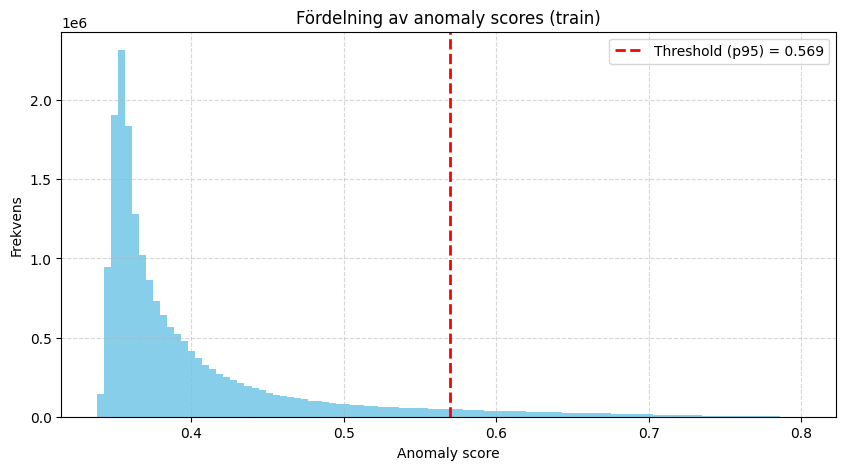

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# === 1. Ladda modell ===
model_path = "model/iforest_local.joblib"
model_data = joblib.load(model_path)
pipe = model_data["pipeline"]
FEATURES = model_data["features"]
thr_train = model_data["threshold"]
print(f"✅ Modell laddad (tröskel ≈ {thr_train:.3f})")

# === 2. Läs träningsdata ===
TRAIN = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_train.parquet"
df_tr = pd.read_parquet(TRAIN)
X_tr = df_tr[FEATURES].values

# === 3. Beräkna anomalipoäng ===
scores_tr = -pipe.named_steps["iforest"].score_samples(
    pipe.named_steps["scaler"].transform(X_tr)
)
print(f"Antal poäng: {len(scores_tr):,}")
print(f"Min={np.min(scores_tr):.3f}, Max={np.max(scores_tr):.3f}, P95={np.quantile(scores_tr,0.95):.3f}")

# === 4. Plotta ===
plt.figure(figsize=(10,5))
counts, bins, patches = plt.hist(scores_tr, bins=100, color="skyblue", edgecolor="none")
plt.axvline(thr_train, color="red", linestyle="--", linewidth=2, label=f"Tröskel (p95) = {thr_train:.3f}")
plt.title("Fördelning av anomalipoäng (träning)")
plt.xlabel("Anomalipoäng")
plt.ylabel("Frekvens")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
# === 5. Validering ===
VAL = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_val.parquet"
df_val = pd.read_parquet(VAL)
X_val  = df_val[FEATURES].values

# Beräkna anomalipoäng på valideringsdata
scores_val = -pipe.named_steps["iforest"].score_samples(
    pipe.named_steps["scaler"].transform(X_val)
)

# Hur många observationer flaggas som anomalier med träningströskeln?
val_rate = (scores_val >= thr_train).mean()
print(f"Anomalifrekvens validering = {val_rate*100:.2f}% (tröskel = {thr_train:.3f})")


Validation anomaly rate = 1.61% (threshold = 0.569)


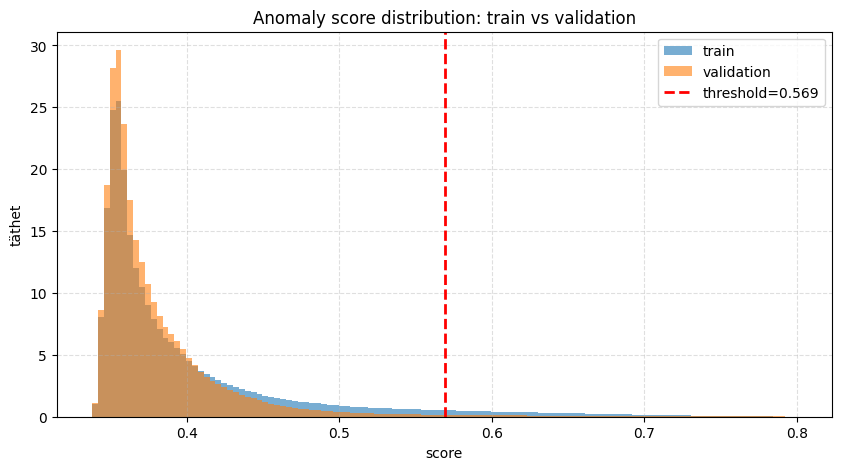

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(scores_tr, bins=120, density=True, alpha=0.6, label="träning")
plt.hist(scores_val, bins=120, density=True, alpha=0.6, label="validering")
plt.axvline(thr_train, color="red", ls="--", lw=2, label=f"tröskel={thr_train:.3f}")
plt.title("Fördelning av anomalipoäng: träning vs validering")
plt.xlabel("poäng"); plt.ylabel("täthet"); plt.legend(); plt.grid(True, ls="--", alpha=0.4)
plt.show()


In [ ]:
TEST = "/home/siffror/projects/ds-demo/iiot-poc/data/femto/features_test.parquet"
df_te = pd.read_parquet(TEST)
X_te  = df_te[FEATURES].values

scores_te = -pipe.named_steps["iforest"].score_samples(
    pipe.named_steps["scaler"].transform(X_te)
)

test_rate = (scores_te >= thr_train).mean()
print(f"Anomalifrekvens test = {test_rate*100:.2f}% (tröskel = {thr_train:.3f})")


Test anomaly rate = 0.60% (threshold = 0.569)


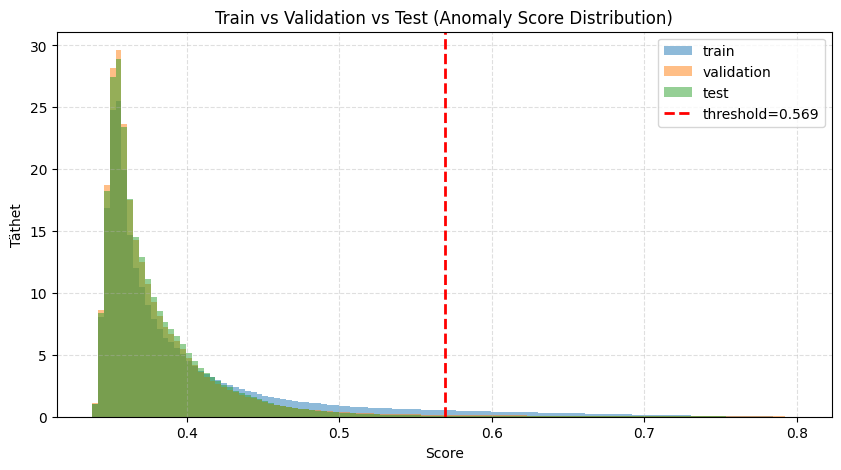

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(scores_tr, bins=120, density=True, alpha=0.5, label="träning")
plt.hist(scores_val, bins=120, density=True, alpha=0.5, label="validering")
plt.hist(scores_te,  bins=120, density=True, alpha=0.5, label="test")
plt.axvline(thr_train, color="red", ls="--", lw=2, label=f"tröskel={thr_train:.3f}")
plt.title("Träning vs Validering vs Test (Fördelning av anomalipoäng)")
plt.xlabel("Poäng"); plt.ylabel("Täthet"); plt.legend(); plt.grid(True, ls="--", alpha=0.4)
plt.show()


In [ ]:
from joblib import dump
dump({
    "pipeline": pipe,
    "features": FEATURES,
    "threshold": thr_train,
}, "model/iforest_final.joblib")
print("✅ sparad Modell: model/iforest_final.joblib")


✅ Sparad modell: model/iforest_final.joblib
